## Problem Set 1

### Introduction
Typically when we train a Convolutional Neural Network as an end-to-end image classifier, we input an image to the network, which gets propagated through the network (feed forward).

We then obtain our posterior probabilities at the end of the network.

However, there is no “rule” that says we must allow the image to forward propagate through the entire network that includes the head. Instead, we can:

1) Stop propagation at a layer before the head of the network (such as an activation or pooling layer).

2) Extract the logits at this layer.

3) Treat the values as a feature vector.

Now these feature vectors can be utilized in other downstream tasks like classification. Our aim is to create a system where an input query image will be responded by a number of  images that have strong resemblance to the query image. This particular task is called **similarity search**. A naive way to perform this task, would be to compare images based on pixel values, patches, or some other high level feature taken from the image itself. You are askd to use the ResNet-50 architecture to produce features that can represent a concept aka a face with specific characteristics.

### PS1.1 Loading of Dataset in Colab (5 points)

Create a jupyter notebook (eg on Google Colab) and download the LFW dataset, from [here](http://vis-www.cs.umass.edu/lfw/).

You can manually download the dataset using the above link and then upload to colab or altelnatively you can issue in colab the commands shown below


In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xvf /content/lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

### PS1.2 Using CNN for Feature Extraction (25 points)

Use ResNet50 to extract features vectors from raw images. You can use TF or Pytorch APIs to:

* Obtain a ResNet-50  model pre-trained on a dataset such as ImageNet.
* Perform necessary preprocessing on the images before feeding them into the network.
* Extract the features from the penultimate layer of the network (before the fully connected layer - the classification head).
* Store the features in a dictionary, where the key is the name of the image and the value is the feature vector.


###importing necessary libraries

In [ ]:
# importing necessary libraries
import torch
import torchvision
import numpy as np
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as T
import os
from os import walk
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt

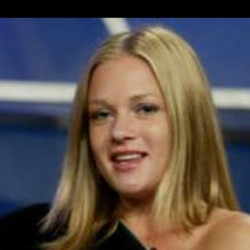

In [ ]:
# testing with an image
img = read_image("lfw/AJ_Cook/AJ_Cook_0001.jpg")

img = T.ToPILImage()(img)
img.show()


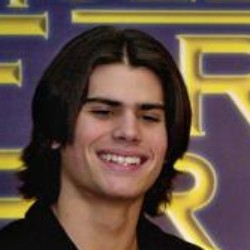

In [ ]:
# testing another image
img1 = read_image("lfw/AJ_Lamas/AJ_Lamas_0001.jpg")

img1 = T.ToPILImage()(img1)
img1.show()

###Prepping to read in all the images files

getting the paths to all the files in the dataset

In [ ]:

def get_file_list(root_dir):
    file_list = []
    filenames_only = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
                file_list.append(os.path.join(root, filename))
                filenames_only.append(filename)
                counter += 1
    return file_list, filenames_only


# path to the datasets
root_dir = 'lfw'
filepaths, filenames_only = get_file_list(root_dir)
filepaths = sorted(filepaths)
filenames_only = sorted(filenames_only)

In [ ]:
print(len(filepaths))
print(len(filenames_only))

13233
13233


In [ ]:
print(filenames_only[:10])

['AJ_Cook_0001.jpg', 'AJ_Lamas_0001.jpg', 'Aaron_Eckhart_0001.jpg', 'Aaron_Guiel_0001.jpg', 'Aaron_Patterson_0001.jpg', 'Aaron_Peirsol_0001.jpg', 'Aaron_Peirsol_0002.jpg', 'Aaron_Peirsol_0003.jpg', 'Aaron_Peirsol_0004.jpg', 'Aaron_Pena_0001.jpg']


In [ ]:
print(filepaths[-10:])

['lfw/Zoe_Ball/Zoe_Ball_0001.jpg', 'lfw/Zoran_Djindjic/Zoran_Djindjic_0001.jpg', 'lfw/Zoran_Djindjic/Zoran_Djindjic_0002.jpg', 'lfw/Zoran_Djindjic/Zoran_Djindjic_0003.jpg', 'lfw/Zoran_Djindjic/Zoran_Djindjic_0004.jpg', 'lfw/Zorica_Radovic/Zorica_Radovic_0001.jpg', 'lfw/Zulfiqar_Ahmed/Zulfiqar_Ahmed_0001.jpg', 'lfw/Zumrati_Juma/Zumrati_Juma_0001.jpg', 'lfw/Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg', 'lfw/Zydrunas_Ilgauskas/Zydrunas_Ilgauskas_0001.jpg']


###Preprocessing the images

In [ ]:
# this data_array holds the tensors of each image to be fed into the ResNet50
data_array = []
for path in filepaths:
  img = read_image(path)
  data_array.append(img)

###Initialize the ResNet50 model from pytorch

In [ ]:
# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms(antialias=True)

###Extracting the feacture vectors from ResNet50 pretrained model from pytorch.models and saving them in a dictionary ( name of image is the key and the feature vector is the value)


In [ ]:
# getting the features of all the images

n = len(filepaths)

In [ ]:
def extract_features_from_ResNet50(n, names, images, model, preprocess):
  features = {}

  for i in range(n):
    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(images[i]).unsqueeze(0)

    # use the model to extract the features
    features[names[i]] = model(batch)
    # normalize the features
    features[names[i]] = features[names[i]] / torch.linalg.vector_norm(features[names[i]])
    # turn it into numpy array
    features[names[i]] = features[names[i]].detach().numpy().flatten()

  return features

features = extract_features_from_ResNet50(n, filenames_only, data_array, model, preprocess)


####Print out a copule of elements from the feature dictionary

In [ ]:
first_element = features[filenames_only[0]]
print(f" {filenames_only[0]} : {first_element}") # name of image : feature vector

last_element = features[filenames_only[99]]
print(f" {filenames_only[99]} : {first_element}") # name of image : feature vector

 AJ_Cook_0001.jpg : [-2.04787813e-02  9.57666337e-03  1.87128615e-02 -9.44390427e-03
  4.03474644e-03 -2.51345783e-02 -3.85452155e-03 -8.21128767e-03
  5.01353480e-03 -1.03762476e-02 -1.50735825e-02 -1.55181857e-02
 -5.57530392e-03 -6.94666663e-03 -4.07872722e-03  4.07886179e-03
 -2.56236345e-02 -2.00975966e-02 -1.24366861e-02 -9.44608916e-03
 -1.84211750e-02 -7.35932682e-03  2.07080529e-03 -6.89200498e-03
 -7.56335491e-03 -3.91122140e-03 -1.14727356e-02 -6.76836492e-03
 -2.70840600e-02 -1.64044052e-02 -7.22789159e-03 -1.37483515e-02
 -6.76891441e-03 -7.70199718e-03 -5.47568640e-03 -2.18876638e-03
 -1.04284715e-02 -1.55445449e-02 -7.60690263e-03  9.26642399e-03
 -1.18082110e-02 -1.83462370e-02 -2.03568321e-02 -5.90217998e-03
 -1.77899301e-02 -2.03905074e-04 -1.88749414e-02 -2.02453770e-02
 -6.53270166e-03 -1.60098542e-02  2.29762699e-02 -2.35952288e-02
 -1.56903230e-02 -2.24186629e-02 -1.69523247e-02 -3.70662240e-03
 -3.05776671e-02 -3.76194203e-03 -2.25607418e-02  1.49789930e-03
 -1.8

In [ ]:
features[filenames_only[0]].shape

(1000,)

### PS 1.3 Retrieving most similar images (15 points)

Use a nearest neighbor algorithm such as [this](https://scikit-learn.org/stable/modules/neighbors.html) to obtain the 10 most similar images to 5 query images of your choice. Choose the results that best illustrate the effectiveness of your system.


In [ ]:
# import libraries
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
# getting the list from the feature dictionary
feature_list = list(features.values())
print(type(feature_list))
print((feature_list[0]).shape)

<class 'list'>
(1000,)


In [ ]:
# fit the KNN model to find 10 nearest neighbots
neighbors = NearestNeighbors(n_neighbors=11, algorithm='brute', metric='euclidean').fit(feature_list)

In [ ]:
# find 10 images that are similar to the first 5 images in the dataset
similar_people = []
for i in range(5):
  distances, indices = neighbors.kneighbors([features[filenames_only[i]]])
  similar_people.append((distances, indices))

In [ ]:
# testing the 10 similar people similar to the first person at index 0
similar_people[0][1][0]

array([    0,  9819,  9818, 12667, 11722,  2521,   370,  8836, 11655,
        9619,  6324])

###showing the results

In [ ]:
def print_images_in_grid(images):
  fig = plt.figure(figsize=(10., 10.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

  for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(mpimg.imread(im))

  plt.show(images)

In [ ]:
def get_similar_people(i):
  ten = similar_people[i][1][0]
  similar_images = [filepaths[ten[i]] for i in range(1, 11)]
  return similar_images

###First image and 10 similar images

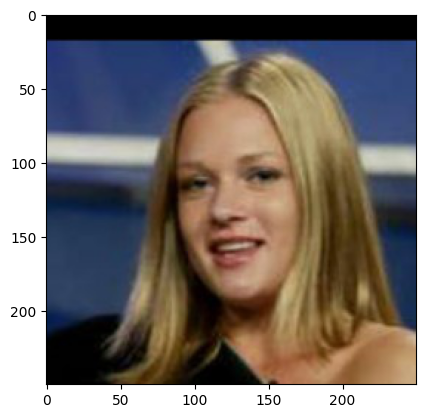

In [ ]:
plt.imshow(mpimg.imread(filepaths[0]))

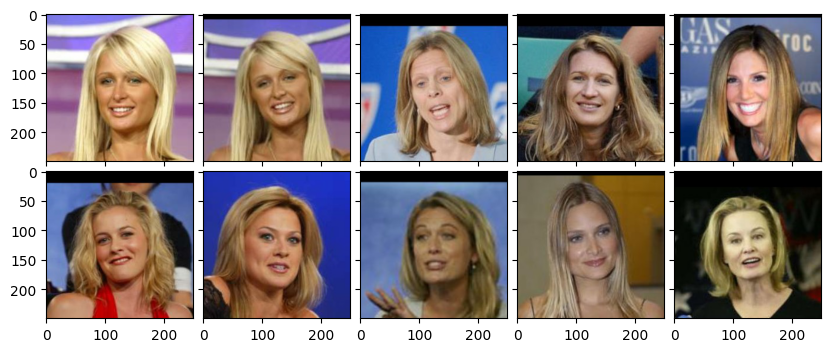

In [ ]:
print_images_in_grid(get_similar_people(0))

###Second image and 10 similar images

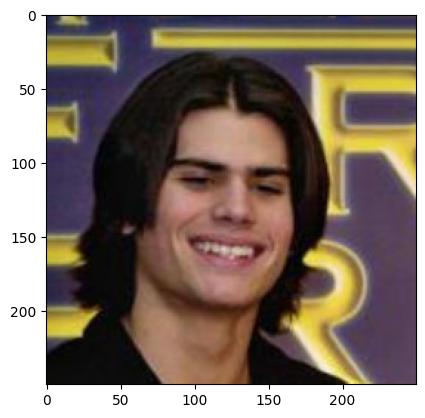

In [ ]:
plt.imshow(mpimg.imread(filepaths[1]))

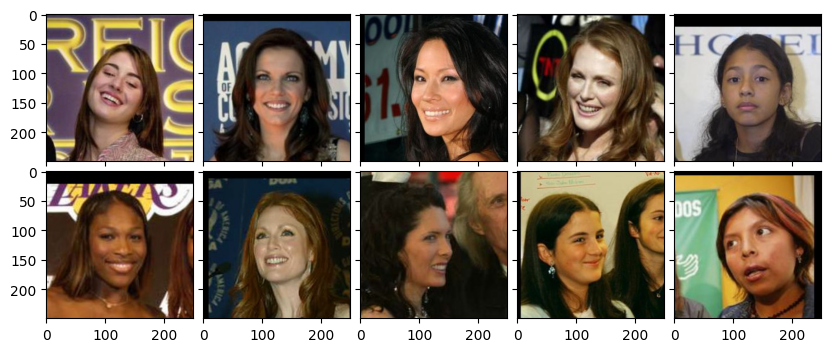

In [ ]:
print_images_in_grid(get_similar_people(1))

###Third image and 10 similar images

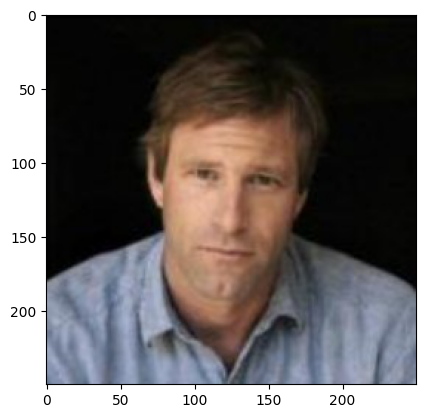

In [ ]:
plt.imshow(mpimg.imread(filepaths[2]))

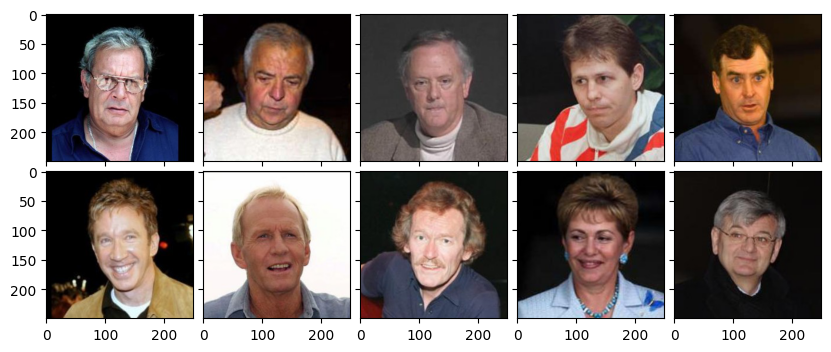

In [ ]:
print_images_in_grid(get_similar_people(2))

###Fourth image and 10 similar images

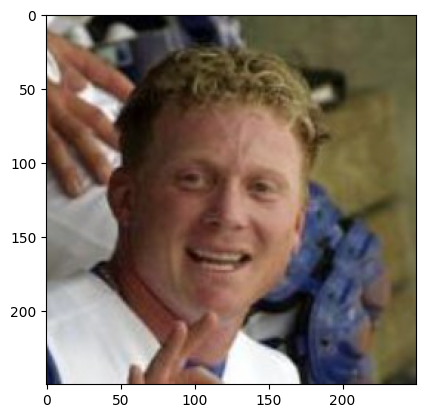

In [ ]:
plt.imshow(mpimg.imread(filepaths[3]))

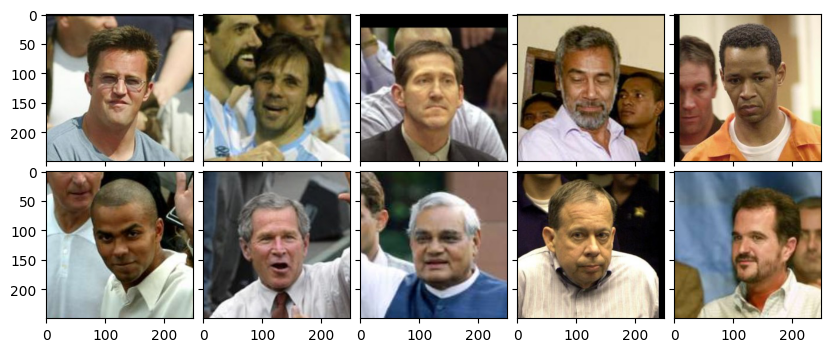

In [ ]:
print_images_in_grid(get_similar_people(3))

###Fifth image and 10 similar images

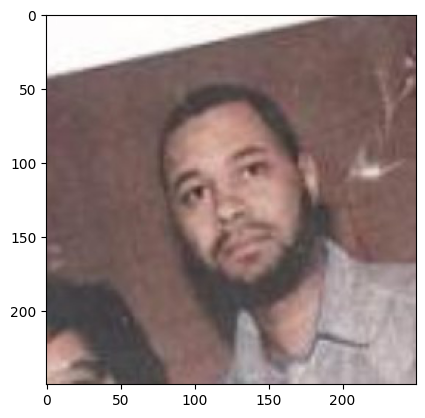

In [ ]:
plt.imshow(mpimg.imread(filepaths[4]))

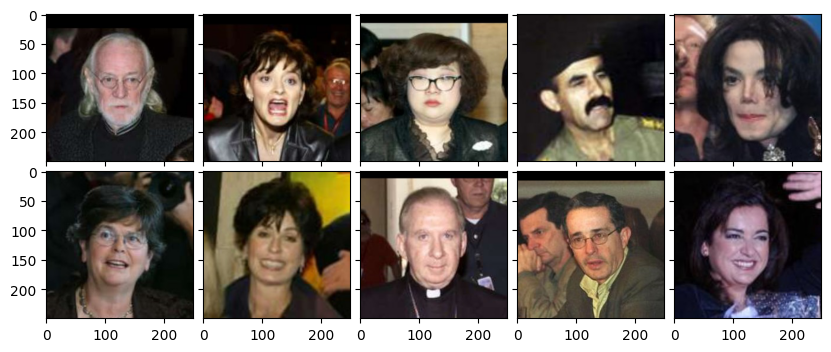

In [ ]:
print_images_in_grid(get_similar_people(4))

References:

1. https://scikit-learn.org/0.16/datasets/labeled_faces.html
2. https://pytorch.org/vision/stable/models.html
